        id  rating                                       comment  Скорость  \
0  2945792       5                                       спасибо         0   
1  3234340       5                                      спасибо!         0   
2  3380332       5                                      Отлично          0   
3  3381812       5  Благодарю за оперативное решение проблемы !          1   
4  3691620       5                                      Спасибо          0   

   Качество выполнения  Качество сотрудников  Выполнение заявки  Вопрос решен  \
0                    0                     0                  0             1   
1                    0                     0                  0             1   
2                    1                     0                  0             0   
3                    0                     0                  1             1   
4                    0                     0                  0             1   

   Вопрос не решен  
0                0  
1 

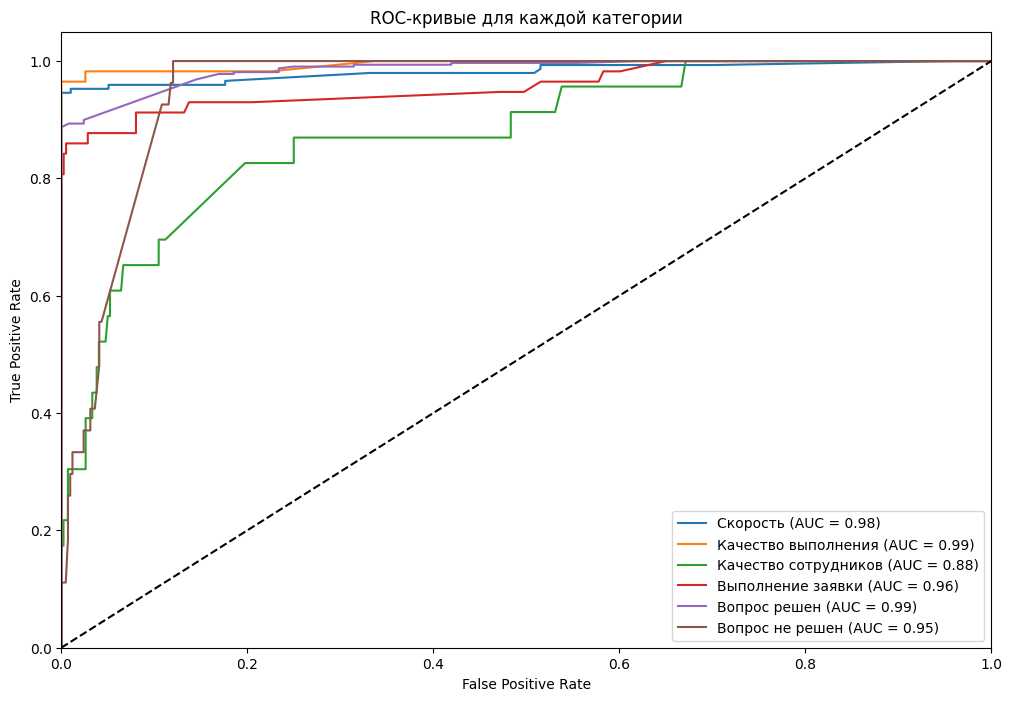

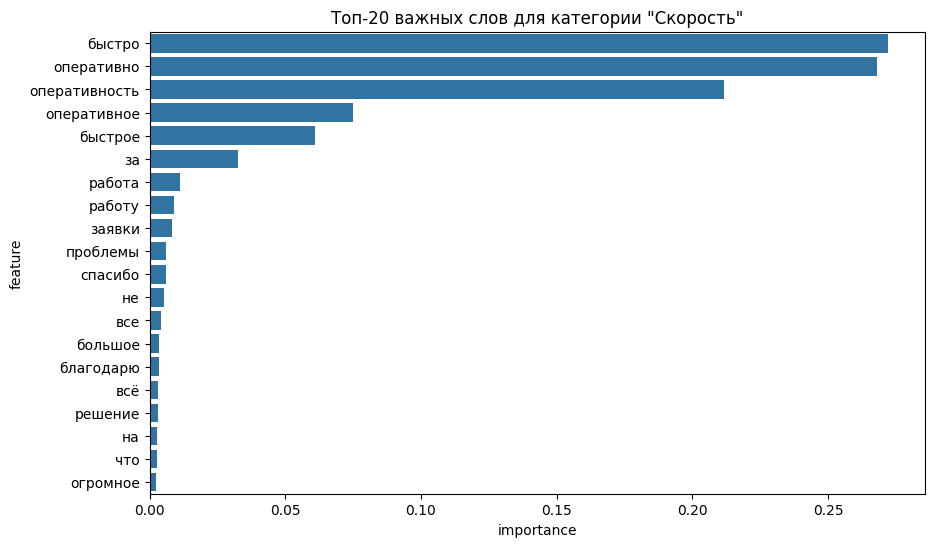


Итоговые метрики лучшей модели:
ROC-AUC: 0.9584
R2: 0.5502
MSE: 0.0391
MAE: 0.0391
RMSE: 0.1978

Кросс-валидация R2: 0.5631
Кросс-валидация MAE: 0.0405


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Загрузка данных
data = pd.read_csv('comments_with_binary_categories.csv')

# Просмотр структуры данных
print(data.head())
print("\nИнформация о данных:")
print(data.info())
print("\nОписательная статистика:")
print(data.describe())

# Проверка баланса классов
categories = ['Скорость', 'Качество выполнения', 'Качество сотрудников', 'Выполнение заявки', 'Вопрос решен', 'Вопрос не решен']
for category in categories:
    print(f"\nРаспределение для категории '{category}':")
    print(data[category].value_counts(normalize=True))

# Удаление дубликатов
data = data.drop_duplicates(subset=['id', 'comment'], keep='first')

# Обработка текста
data['comment'] = data['comment'].str.lower()  # приведение к нижнему регистру
data['comment'] = data['comment'].str.replace('[^\w\s]', '')  # удаление пунктуации

# Разделение на признаки и целевую переменную
X = data['comment']
y = data[categories]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Векторизация текста
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Модель логистической регрессии
log_reg = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
log_reg.fit(X_train_vec, y_train)

# Предсказания
y_pred_log = log_reg.predict_proba(X_test_vec)

# Оценка модели
roc_auc_log = roc_auc_score(y_test, y_pred_log, multi_class='ovr')
print(f"ROC-AUC для логистической регрессии: {roc_auc_log:.4f}")

# Кросс-валидация
cv_r2_log = cross_val_score(log_reg, X_train_vec, y_train, cv=5, scoring='r2')
cv_mae_log = cross_val_score(log_reg, X_train_vec, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"R2 на кросс-валидации (логистическая регрессия): {np.mean(cv_r2_log):.4f}")
print(f"MAE на кросс-валидации (логистическая регрессия): {-np.mean(cv_mae_log):.4f}")

# Модель случайного леса
rf = OneVsRestClassifier(RandomForestClassifier(random_state=42))
rf.fit(X_train_vec, y_train)

# Предсказания
y_pred_rf = rf.predict_proba(X_test_vec)

# Оценка модели
roc_auc_rf = roc_auc_score(y_test, y_pred_rf, multi_class='ovr')
print(f"\nROC-AUC для случайного леса: {roc_auc_rf:.4f}")

# Кросс-валидация
cv_r2_rf = cross_val_score(rf, X_train_vec, y_train, cv=5, scoring='r2')
cv_mae_rf = cross_val_score(rf, X_train_vec, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"R2 на кросс-валидации (случайный лес): {np.mean(cv_r2_rf):.4f}")
print(f"MAE на кросс-валидации (случайный лес): {-np.mean(cv_mae_rf):.4f}")

# Модель XGBoost
xgb = OneVsRestClassifier(XGBClassifier(random_state=42, eval_metric='logloss'))
xgb.fit(X_train_vec, y_train)

# Предсказания
y_pred_xgb = xgb.predict_proba(X_test_vec)

# Оценка модели
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb, multi_class='ovr')
print(f"\nROC-AUC для XGBoost: {roc_auc_xgb:.4f}")

# Кросс-валидация
cv_r2_xgb = cross_val_score(xgb, X_train_vec, y_train, cv=5, scoring='r2')
cv_mae_xgb = cross_val_score(xgb, X_train_vec, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"R2 на кросс-валидации (XGBoost): {np.mean(cv_r2_xgb):.4f}")
print(f"MAE на кросс-валидации (XGBoost): {-np.mean(cv_mae_xgb):.4f}")

# Подбор параметров для XGBoost (как лучшей модели)
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                          cv=3, scoring='roc_auc_ovr', n_jobs=-1)
grid_search.fit(X_train_vec, y_train)

# Лучшие параметры
print("\nЛучшие параметры для XGBoost:")
print(grid_search.best_params_)

# Лучшая модель
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict_proba(X_test_vec)

# Оценка лучшей модели
roc_auc_best = roc_auc_score(y_test, y_pred_best, multi_class='ovr')
print(f"ROC-AUC для лучшей модели XGBoost: {roc_auc_best:.4f}")

# ROC-кривые для каждой категории
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test[category], y_pred_best[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{category} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для каждой категории')
plt.legend(loc="lower right")
plt.show()

# Важность признаков
feature_importances = best_xgb.estimators_[0].feature_importances_
features = vectorizer.get_feature_names_out()
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
importance_df = importance_df.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Топ-20 важных слов для категории "Скорость"')
plt.show()

# Предсказания для всех метрик
y_pred = best_xgb.predict(X_test_vec)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nИтоговые метрики лучшей модели:")
print(f"ROC-AUC: {roc_auc_best:.4f}")
print(f"R2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Кросс-валидация для лучшей модели
cv_r2 = cross_val_score(best_xgb, X_train_vec, y_train, cv=5, scoring='r2')
cv_mae = cross_val_score(best_xgb, X_train_vec, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"\nКросс-валидация R2: {np.mean(cv_r2):.4f}")
print(f"Кросс-валидация MAE: {-np.mean(cv_mae):.4f}")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
import re

# Скачиваем необходимые ресурсы NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Инициализация стоп-слов и стеммера для русского языка
stop_words = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# Загрузка данных
df = pd.read_csv('comments_with_binary_categories.csv', encoding='utf-8')

# Проверим данные
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nСтатистика по категориям:")
print(df.iloc[:, 3:].sum())

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление специальных символов и цифр
    text = re.sub(r'[^а-яё\s]', '', text)
    
    # Токенизация
    tokens = word_tokenize(text, language='russian')
    
    # Удаление стоп-слов и стемминг
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

# Применяем предобработку к комментариям
df['processed_comment'] = df['comment'].apply(preprocess_text)

# Разделяем данные на признаки (X) и целевую переменную (y)
X = df['processed_comment']
y = df.iloc[:, 3:8]  # Категории: Скорость, Качество выполнения, Качество сотрудников, Выполнение заявки, Вопрос решен

# Проверим баланс классов
print("\nРаспределение по категориям:")
print(y.sum())

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем пайплайн для обработки текста и классификации
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced')))
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = pipeline.predict_proba(X_test)

# Рассчитываем ROC-AUC для каждой категории
roc_auc_scores = []
for i in range(len(y_test.columns)):
    roc_auc = roc_auc_score(y_test.iloc[:, i], y_pred[i][:, 1])
    roc_auc_scores.append(roc_auc)
    print(f"ROC-AUC для '{y_test.columns[i]}': {roc_auc:.4f}")

# Средний ROC-AUC
print(f"\nСредний ROC-AUC: {np.mean(roc_auc_scores):.4f}")

# Отчет по классификации
y_pred_labels = pipeline.predict(X_test)
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_labels, target_names=y.columns))

# Визуализация ROC-AUC для каждой категории
plt.figure(figsize=(10, 6))
sns.barplot(x=y.columns, y=roc_auc_scores, palette='viridis')
plt.title('ROC-AUC по категориям')
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.ylabel('ROC-AUC Score')
plt.tight_layout()
plt.show()

# Визуализация распределения категорий
plt.figure(figsize=(10, 6))
y.sum().plot(kind='bar')
plt.title('Распределение комментариев по категориям')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Примеры предсказаний
sample_comments = [
    "спасибо за быстрый ответ и решение проблемы",
    "мастер пришел быстро и качественно все сделал",
    "все отлично, вопрос решен",
    "сотрудники вежливые и профессиональные",
    "ожидал большего от качества выполнения работ"
]

# Преобразуем примеры
processed_samples = [preprocess_text(comment) for comment in sample_comments]

# Получаем предсказания
sample_pred = pipeline.predict_proba(processed_samples)

# Выводим результаты
print("\nПримеры предсказаний:")
for comment, pred in zip(sample_comments, sample_pred):
    print(f"\nКомментарий: '{comment}'")
    for i, category in enumerate(y.columns):
        print(f"{category}: {pred[i][1]:.4f}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vovan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vovan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


        id  rating                                       comment  Скорость  \
0  2945792       5                                       спасибо         0   
1  3234340       5                                      спасибо!         0   
2  3380332       5                                      Отлично          0   
3  3381812       5  Благодарю за оперативное решение проблемы !          1   
4  3691620       5                                      Спасибо          0   

   Качество выполнения  Качество сотрудников  Выполнение заявки  Вопрос решен  \
0                    0                     0                  0             1   
1                    0                     0                  0             1   
2                    1                     0                  0             0   
3                    0                     0                  1             1   
4                    0                     0                  0             1   

   Вопрос не решен  
0                0  
1 

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/russian/[0m

  Searched in:
    - 'C:\\Users\\vovan/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\vovan\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************
